## Task-3: Variational Autoencoder (VAE)

Implement a VAE to learn latent representations of images, generate new samples, and analyze the effect of latent dimensionality

**Instructions:**

**Dataset:** Use MNIST, and preprocess      
**Model Implementation**:      
- Encoder: 3–4 Conv layers → flatten → Linear → output μ and log(σ²)
- Use latent dimension of 128
- Decoder: transpose convolutions → reconstruct image.  
    
**Training**            
- Loss: Reconstruction (MSE or BCE), KL divergence term
- Optimizer: Adam
- Train for 50 epochs.

- Visualize reconstruction and latent space evolution.
- Generation and Visualization: Sample random z vectors → generate images.
- Interpolate between two z vectors to observe smooth transitions.
- Change latent dimension to 256, retrain the model, and visualize generated images and reconstruction quality.

**Deliverable:**

- Jupyter notebook with clear code and comments.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from sklearn.manifold import TSNE

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

BATCH_SIZE = 128

Using device: cuda


# Data loaders

In [8]:

transform = transforms.Compose([
    transforms.ToTensor(),         
])

train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

print(f"MNIST Training set loaded. Total samples: {len(train_dataset)}")

MNIST Training set loaded. Total samples: 60000


https://ludovico-buizza.medium.com/generating-things-with-vaes-882c6e3b688d

Convolution:     
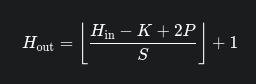

Transposed convolution:     
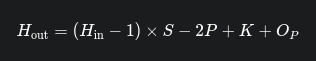

# VAE architecture

In [5]:
class VAE(nn.Module):

    def __init__(self, latent_dims=128):
        super(VAE, self).__init__()
        self.latent_dims = latent_dims
        
        # Mapping 28x28x1 -> 4x4x128
        self.encoder = nn.Sequential(
            # 28x28 -> 14x14
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), #(28-3+2)/2 + 1 = 14
            nn.LeakyReLU(),
            # 14x14 -> 7x7
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #(14-3+2)/2 + 1 = 7
            nn.LeakyReLU(),
            # 7x7 -> 4x4 
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), #(7-3+2)/2 + 1 = 4
            nn.LeakyReLU()
        )

        try:
            dummy_input = torch.zeros(1, 1, 28, 28)
            with torch.no_grad():
                output = self.encoder(dummy_input)
                
            FINAL_CONV_DIM = torch.flatten(output, start_dim=1).shape[1]
            
            self.encoder_final_channels = output.shape[1] # 128
            self.encoder_final_hw = output.shape[2]      # 4 (H=W)
            
        except Exception:
            print("Warning: Dynamic calculation failed. Using static FINAL_CONV_DIM=2048.")
            FINAL_CONV_DIM = 2048 
            self.encoder_final_channels = 128
            self.encoder_final_hw = 4
        
        # FC layers = latent space mapping
        self.fc_mu = nn.Linear(FINAL_CONV_DIM, self.latent_dims)
        self.fc_var = nn.Linear(FINAL_CONV_DIM, self.latent_dims)

        # Transpose convolution = image reconstruction
        self.decoder_input = nn.Linear(self.latent_dims, FINAL_CONV_DIM) 
        
        self.decoder = nn.Sequential(
            # 4x4 -> 7x7
            nn.ConvTranspose2d(self.encoder_final_channels, 64, 
                               kernel_size=3, stride=2, padding=1, output_padding=0), #(4-1)x2-2+3+0 = 7
            nn.LeakyReLU(), # H_out = 7
            
            # 7x7 -> 14x14
            nn.ConvTranspose2d(64, 32, 
                               kernel_size=4, stride=2, padding=1),  #(7-1)x2-2+4+0 = 14
            nn.LeakyReLU(), # H_out = 14
            
            # 14x14 -> 28x28
            nn.ConvTranspose2d(32, 16, 
                               kernel_size=4, stride=2, padding=1), #(14-1)x2-2+4+0 = 28
            nn.LeakyReLU(), # H_out = 28
        )
        # I used kernel_size=4 instead of 3 in the upsampling layers (stride=2) because K=4 (K >= 2xStride - 1) 
        # ensures uniform filter overlap, which is crucial for maximizing reconstruction smoothness and 
        # preventing checkerboard artifacts typical of K=3.
        
        self.final_layer = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid() 
        )

    # The encoder maps the input image (x) to the parameters of a distribution: the mean (mu) and log-variance (log_var)
    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        return mu, log_var
    # The VAE samples a latent vector (z) from N(mu, sigma^2) using the reparameterization trick 
    # (z = mu + sigma * epsilon) to maintain differentiability
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    # The latent vector (z) is passed to the decoder to reconstruct the image (x_hat). 
    # Mu and log_var are returned for the KL divergence loss calculation.
    def decode(self, z):
        result = self.decoder_input(z)
        
        # Transform to [B, Channels, H, W]
        result = result.view(
            -1, 
            self.encoder_final_channels, 
            self.encoder_final_hw,      
            self.encoder_final_hw       
        )
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparametrize(mu, log_var)
        return self.decode(z), x, mu, log_var

# Training loop and visualization functions

In [ ]:
def vae_loss(reconstruction, x, mu, log_var):
    
    reconstruction_loss = F.binary_cross_entropy(
        reconstruction, 
        x, 
        reduction='sum'
    )
    
    reconstruction_loss /= x.size(0)

    # KL = -0.5 * suma(1 + log(sigma^2) - mu^2 - sigma^2)
    # log_var = log(sigma^2).
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) #forces Z to be from normal distribution
    
    # scaling by batch size
    kl_divergence /= x.size(0)
    
    return reconstruction_loss + kl_divergence, reconstruction_loss, kl_divergence

# We want to minimize reconstruction loss.
# We want to stablizie KL:
# If it’s too small, the model ignores the latent space — the encoder outputs nearly identical vectors for all inputs.
# If it’s too large, the latent space is chaotic — the model can’t generate meaningful samples.

In [44]:
def train_vae(model, loader, optimizer, num_epochs, device, weights_dir):
    model.to(device)
    model.train()
    history = {'loss': [], 'recon_loss': [], 'kl_div': []}
    
    print(f"Starting VAE training for {num_epochs} epochs on {device}...")

    SAVE_INTERVAL = 10
    os.makedirs(weights_dir, exist_ok=True)

    for epoch in range(num_epochs):
        total_loss = 0
        total_recon_loss = 0
        total_kl_div = 0
        
        for i, (x, _) in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            x = x.to(device)
            
            #forward pass
            reconstruction, _, mu, log_var = model(x)
            
            loss, recon_loss, kl_div = vae_loss(reconstruction, x, mu, log_var)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * x.size(0)
            total_recon_loss += recon_loss.item() * x.size(0)
            total_kl_div += kl_div.item() * x.size(0)

        avg_loss = total_loss / len(loader.dataset)
        avg_recon_loss = total_recon_loss / len(loader.dataset)
        avg_kl_div = total_kl_div / len(loader.dataset)

        history['loss'].append(avg_loss)
        history['recon_loss'].append(avg_recon_loss)
        history['kl_div'].append(avg_kl_div)
        
        print(f"Epoch {epoch+1} done. Loss: {avg_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_div:.4f})")

        # checkpoint snapchots fro latent space evolution visualization
        if (epoch + 1) % SAVE_INTERVAL == 0 or (epoch + 1) == 1 or (epoch + 1) == num_epochs:
            weights_path = os.path.join(weights_dir, f"vae_weights_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), weights_path)
            
        # save final model
        if (epoch + 1) == num_epochs and (epoch + 1) % SAVE_INTERVAL != 0:
             weights_path = os.path.join(weights_dir, f"vae_weights_epoch_{epoch+1}.pth")
             torch.save(model.state_dict(), weights_path)
        
    return model, history

In [ ]:
def visualize_reconstruction(model, loader, device):
    model.eval()

    num_classes = 10
    selected_images = []
    found_labels = set()
    data_iterator = iter(loader)
    
    while len(found_labels) < num_classes:
        try:
            x_batch, y_batch = next(data_iterator)
        except StopIteration:
            print("Warning: Dataset exhausted before finding all 10 classes.")
            break

        for i in range(len(y_batch)):
            label = y_batch[i].item()
            if label not in found_labels:
                selected_images.append((x_batch[i], label))
                found_labels.add(label)
        
        # One reconstructed image per class
        selected_images.sort(key=lambda item: item[1])
        selected_images = selected_images[:num_classes]
    
    if not selected_images:
        print("Error: Could not find any images.")
        return
        
    x_display = torch.stack([img for img, label in selected_images]).to(device)
    labels_display = [label for img, label in selected_images]

    with torch.no_grad():
        reconstruction, _, _, _ = model(x_display)
    
    fig, axes = plt.subplots(2, num_classes, figsize=(18, 4))
    
    for i in range(num_classes):
        axes[0, i].imshow(x_display[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f"Class {labels_display[i]}", fontsize=12)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(reconstruction[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

        if i == 0:
            axes[0, i].set_ylabel("Original", fontsize=12, rotation=0, ha='right', labelpad=20)
            axes[1, i].set_ylabel("Reconstruction", fontsize=12, rotation=0, ha='right', labelpad=20)
        
    plt.tight_layout()
    plt.show()

def plot_loss_evolution(history):
    """Visualizes the evolution of VAE losses over epochs."""
    
    epochs = range(1, len(history['loss']) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['loss'], label='Total VAE Loss', linewidth=2)
    plt.plot(epochs, history['recon_loss'], label='Reconstruction Loss (BCE)', linestyle='--')
    plt.plot(epochs, history['kl_div'], label='KL Divergence', linestyle='-.')
    
    plt.title(f'VAE Loss Evolution over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss Value', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.6)
    plt.show()

def visualize_latent_structure_evolution(model_class, latent_dims, loader, device, epochs_to_show, weights_dir='./vae_snapshots'):
    """
    t-SNE latent space visualization for different model checkpoints.
    """
    num_plots = len(epochs_to_show)
    fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))
    if num_plots == 1: axes = [axes] 

    model_instance = model_class(latent_dims=latent_dims)
    model_instance.to(device)
    model_instance.eval()
    
    print(f"\nGenerating t-SNE evolution for epochs: {epochs_to_show}...")

    for i, epoch in enumerate(tqdm(epochs_to_show, desc="Processing t-SNE snapshots")):
        weights_path = os.path.join(weights_dir, f"vae_weights_epoch_{epoch}.pth")
        
        try:
            if not os.path.exists(weights_path):
                print(f"\nSkipping epoch {epoch}: Weights file not found at {weights_path}.")
                continue
                
            model_instance.load_state_dict(torch.load(weights_path, map_location=device))
            
        except Exception as e:
            print(f"\nError loading weights for epoch {epoch}: {e}")
            continue
        
        zs, labels = [], []
        
        # Collecting data only for a few batches
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(loader):
                x = x.to(device)
                mu, _ = model_instance.encode(x)
                zs.append(mu.cpu().numpy())
                labels.append(y.numpy())
                if batch_idx >= 50: 
                    break

        zs = np.concatenate(zs)
        labels = np.concatenate(labels)
        
        z_2d = TSNE(n_components=2, random_state=2, init='pca', learning_rate='auto').fit_transform(zs)
      
        ax = axes[i]
        scatter = ax.scatter(z_2d[:,0], z_2d[:,1], c=labels, cmap='tab10', s=5, alpha=0.8)
        ax.set_title(f"Epoch {epoch}", fontsize=12)
        ax.axis('off')
        
        if i == num_plots - 1:
            plt.colorbar(scatter, ax=axes.tolist(), ticks=range(10), label='Digit Class')
            
    #fig.suptitle(f"Latent Space Evolution (t-SNE projection, Latent Dim={latent_dims})", fontsize=16)
    plt.show()

def generate_samples(model, latent_dims, device, num_samples=10):
    model.eval()
    
    # Generating random Z vectors from normal distribution noise
    z = torch.randn(num_samples, latent_dims).to(device)
    
    with torch.no_grad():
        generated_images = model.decode(z) #using decoder to generate new images from Z vectors
        
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 1.5))
    for i in range(num_samples):
        axes[i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle("Generated Samples from Random Z", fontsize=16)
    plt.show()


def interpolate_samples(model, latent_dims, device, num_steps=10, mode='spherical'):
    model.eval()
    
    # 2 random Z vectors
    z1 = torch.randn(1, latent_dims).to(device)
    z2 = torch.randn(1, latent_dims).to(device)
    
    interpolated_images = []

    def slerp(z1, z2, alpha):
        """Spherical Linear Interpolation"""
        # vectors normalization
        z1_norm = z1 / torch.norm(z1, dim=1, keepdim=True)
        z2_norm = z2 / torch.norm(z2, dim=1, keepdim=True)
        
        # angle between vectors
        dot = (z1_norm * z2_norm).sum(dim=1, keepdim=True)
        dot = torch.clamp(dot, -1.0, 1.0)
        theta = torch.acos(dot)
        sin_theta = torch.sin(theta)

        # if vectors are close to each other, we use linear interpolation instead
        if torch.any(sin_theta < 1e-6):
            return (1 - alpha) * z1 + alpha * z2
        return (torch.sin((1 - alpha) * theta) / sin_theta) * z1 + (torch.sin(alpha * theta) / sin_theta) * z2
    
    for i in range(num_steps):
        alpha = i / (num_steps - 1)
        if mode == 'spherical':
            z_interp = slerp(z1, z2, alpha)

        # linear interpolation between 2 vectors 
        else:
            z_interp = z1 * (1 - alpha) + z2 * alpha
        
        with torch.no_grad():
            img = model.decode(z_interp)
            interpolated_images.append(img.squeeze().cpu().numpy())
            
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 1.5))
    for i in range(num_steps):
        axes[i].imshow(interpolated_images[i], cmap='gray')
        axes[i].axis('off')
        
    plt.suptitle("Latent Space Interpolation (Smooth Transitions)", fontsize=16)
    plt.show()

Linear interpolation   
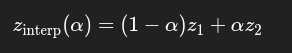

Spherical interpolation   
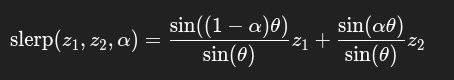

# VAE training: latent dimensions = 128

In [45]:
LATENT_DIM = 128
EPOCHS = 50
LR = 1e-3

model_128 = VAE(latent_dims=LATENT_DIM)
optimizer_128 = optim.Adam(model_128.parameters(), lr=LR)

print("\n\n--- VAE training latent dimensions = 128 ---")
trained_model_128, history_128 = train_vae(
    model_128, 
    train_loader, 
    optimizer_128, 
    EPOCHS, 
    DEVICE,
    './vae_snapshots_d128'
)



--- VAE training latent dimensions = 128 ---
Starting VAE training for 50 epochs on cuda...


Epoch 1/50: 100%|██████████| 469/469 [00:05<00:00, 88.08it/s]


Epoch 1 done. Loss: 174.0802 (Recon: 155.8731, KL: 18.2072)


Epoch 2/50: 100%|██████████| 469/469 [00:05<00:00, 88.29it/s]


Epoch 2 done. Loss: 114.3491 (Recon: 88.9865, KL: 25.3626)


Epoch 3/50: 100%|██████████| 469/469 [00:05<00:00, 90.43it/s]


Epoch 3 done. Loss: 107.6769 (Recon: 82.0524, KL: 25.6244)


Epoch 4/50: 100%|██████████| 469/469 [00:05<00:00, 88.86it/s]


Epoch 4 done. Loss: 105.2001 (Recon: 79.5164, KL: 25.6836)


Epoch 5/50: 100%|██████████| 469/469 [00:05<00:00, 89.99it/s]


Epoch 5 done. Loss: 103.7038 (Recon: 77.9687, KL: 25.7351)


Epoch 6/50: 100%|██████████| 469/469 [00:05<00:00, 89.45it/s]


Epoch 6 done. Loss: 102.7340 (Recon: 77.0154, KL: 25.7186)


Epoch 7/50: 100%|██████████| 469/469 [00:05<00:00, 87.02it/s]


Epoch 7 done. Loss: 101.9677 (Recon: 76.2672, KL: 25.7005)


Epoch 8/50: 100%|██████████| 469/469 [00:05<00:00, 86.64it/s]


Epoch 8 done. Loss: 101.3411 (Recon: 75.7036, KL: 25.6375)


Epoch 9/50: 100%|██████████| 469/469 [00:05<00:00, 88.16it/s]


Epoch 9 done. Loss: 100.9169 (Recon: 75.3133, KL: 25.6036)


Epoch 10/50: 100%|██████████| 469/469 [00:05<00:00, 88.22it/s]


Epoch 10 done. Loss: 100.4300 (Recon: 74.8819, KL: 25.5481)


Epoch 11/50: 100%|██████████| 469/469 [00:05<00:00, 87.95it/s]


Epoch 11 done. Loss: 100.0871 (Recon: 74.6088, KL: 25.4783)


Epoch 12/50: 100%|██████████| 469/469 [00:05<00:00, 90.63it/s]


Epoch 12 done. Loss: 99.7168 (Recon: 74.2892, KL: 25.4276)


Epoch 13/50: 100%|██████████| 469/469 [00:05<00:00, 90.36it/s]


Epoch 13 done. Loss: 99.5099 (Recon: 74.1193, KL: 25.3906)


Epoch 14/50: 100%|██████████| 469/469 [00:05<00:00, 87.71it/s]


Epoch 14 done. Loss: 99.1581 (Recon: 73.8706, KL: 25.2875)


Epoch 15/50: 100%|██████████| 469/469 [00:05<00:00, 89.60it/s]


Epoch 15 done. Loss: 98.9289 (Recon: 73.7097, KL: 25.2191)


Epoch 16/50: 100%|██████████| 469/469 [00:05<00:00, 88.76it/s]


Epoch 16 done. Loss: 98.6538 (Recon: 73.4691, KL: 25.1847)


Epoch 17/50: 100%|██████████| 469/469 [00:05<00:00, 88.98it/s]


Epoch 17 done. Loss: 98.5015 (Recon: 73.3904, KL: 25.1111)


Epoch 18/50: 100%|██████████| 469/469 [00:05<00:00, 91.09it/s]


Epoch 18 done. Loss: 98.2101 (Recon: 73.1391, KL: 25.0710)


Epoch 19/50: 100%|██████████| 469/469 [00:05<00:00, 85.83it/s]


Epoch 19 done. Loss: 98.0599 (Recon: 73.0364, KL: 25.0235)


Epoch 20/50: 100%|██████████| 469/469 [00:05<00:00, 88.42it/s]


Epoch 20 done. Loss: 97.9501 (Recon: 72.9772, KL: 24.9730)


Epoch 21/50: 100%|██████████| 469/469 [00:05<00:00, 91.50it/s]


Epoch 21 done. Loss: 97.7340 (Recon: 72.7847, KL: 24.9492)


Epoch 22/50: 100%|██████████| 469/469 [00:05<00:00, 89.51it/s]


Epoch 22 done. Loss: 97.5737 (Recon: 72.6738, KL: 24.8999)


Epoch 23/50: 100%|██████████| 469/469 [00:05<00:00, 87.45it/s]


Epoch 23 done. Loss: 97.4453 (Recon: 72.5996, KL: 24.8458)


Epoch 24/50: 100%|██████████| 469/469 [00:05<00:00, 87.56it/s]


Epoch 24 done. Loss: 97.3042 (Recon: 72.4484, KL: 24.8559)


Epoch 25/50: 100%|██████████| 469/469 [00:05<00:00, 84.97it/s]


Epoch 25 done. Loss: 97.1227 (Recon: 72.3618, KL: 24.7610)


Epoch 26/50: 100%|██████████| 469/469 [00:05<00:00, 89.22it/s]


Epoch 26 done. Loss: 97.0664 (Recon: 72.2854, KL: 24.7810)


Epoch 27/50: 100%|██████████| 469/469 [00:05<00:00, 87.00it/s]


Epoch 27 done. Loss: 96.9350 (Recon: 72.1891, KL: 24.7459)


Epoch 28/50: 100%|██████████| 469/469 [00:05<00:00, 84.49it/s]


Epoch 28 done. Loss: 96.8084 (Recon: 72.1257, KL: 24.6827)


Epoch 29/50: 100%|██████████| 469/469 [00:04<00:00, 94.71it/s]


Epoch 29 done. Loss: 96.6847 (Recon: 72.0345, KL: 24.6502)


Epoch 30/50: 100%|██████████| 469/469 [00:04<00:00, 95.59it/s]


Epoch 30 done. Loss: 96.6179 (Recon: 71.9796, KL: 24.6383)


Epoch 31/50: 100%|██████████| 469/469 [00:04<00:00, 95.44it/s]


Epoch 31 done. Loss: 96.5094 (Recon: 71.8811, KL: 24.6283)


Epoch 32/50: 100%|██████████| 469/469 [00:04<00:00, 95.09it/s]


Epoch 32 done. Loss: 96.4128 (Recon: 71.8001, KL: 24.6126)


Epoch 33/50: 100%|██████████| 469/469 [00:04<00:00, 95.98it/s]


Epoch 33 done. Loss: 96.3353 (Recon: 71.7828, KL: 24.5525)


Epoch 34/50: 100%|██████████| 469/469 [00:04<00:00, 96.30it/s]


Epoch 34 done. Loss: 96.2401 (Recon: 71.6890, KL: 24.5511)


Epoch 35/50: 100%|██████████| 469/469 [00:04<00:00, 95.06it/s]


Epoch 35 done. Loss: 96.1376 (Recon: 71.6015, KL: 24.5360)


Epoch 36/50: 100%|██████████| 469/469 [00:04<00:00, 95.64it/s]


Epoch 36 done. Loss: 96.0308 (Recon: 71.5341, KL: 24.4967)


Epoch 37/50: 100%|██████████| 469/469 [00:04<00:00, 95.88it/s]


Epoch 37 done. Loss: 95.9479 (Recon: 71.4876, KL: 24.4603)


Epoch 38/50: 100%|██████████| 469/469 [00:04<00:00, 95.98it/s]


Epoch 38 done. Loss: 95.8782 (Recon: 71.4597, KL: 24.4186)


Epoch 39/50: 100%|██████████| 469/469 [00:04<00:00, 95.78it/s]


Epoch 39 done. Loss: 95.8493 (Recon: 71.3955, KL: 24.4538)


Epoch 40/50: 100%|██████████| 469/469 [00:04<00:00, 95.26it/s]


Epoch 40 done. Loss: 95.7687 (Recon: 71.3280, KL: 24.4407)


Epoch 41/50: 100%|██████████| 469/469 [00:04<00:00, 96.05it/s]


Epoch 41 done. Loss: 95.7338 (Recon: 71.3079, KL: 24.4258)


Epoch 42/50: 100%|██████████| 469/469 [00:04<00:00, 95.90it/s]


Epoch 42 done. Loss: 95.6226 (Recon: 71.2313, KL: 24.3913)


Epoch 43/50: 100%|██████████| 469/469 [00:05<00:00, 91.77it/s]


Epoch 43 done. Loss: 95.5698 (Recon: 71.1732, KL: 24.3966)


Epoch 44/50: 100%|██████████| 469/469 [00:04<00:00, 95.31it/s]


Epoch 44 done. Loss: 95.4801 (Recon: 71.1319, KL: 24.3482)


Epoch 45/50: 100%|██████████| 469/469 [00:05<00:00, 90.93it/s]


Epoch 45 done. Loss: 95.4110 (Recon: 71.0711, KL: 24.3399)


Epoch 46/50: 100%|██████████| 469/469 [00:05<00:00, 85.12it/s]


Epoch 46 done. Loss: 95.3933 (Recon: 71.0831, KL: 24.3102)


Epoch 47/50: 100%|██████████| 469/469 [00:05<00:00, 85.37it/s]


Epoch 47 done. Loss: 95.2872 (Recon: 70.9973, KL: 24.2899)


Epoch 48/50: 100%|██████████| 469/469 [00:05<00:00, 87.71it/s]


Epoch 48 done. Loss: 95.2731 (Recon: 70.9905, KL: 24.2827)


Epoch 49/50: 100%|██████████| 469/469 [00:05<00:00, 85.79it/s]


Epoch 49 done. Loss: 95.2243 (Recon: 70.9615, KL: 24.2627)


Epoch 50/50: 100%|██████████| 469/469 [00:05<00:00, 86.31it/s]

Epoch 50 done. Loss: 95.1668 (Recon: 70.8965, KL: 24.2703)



 Training loss (D=128)


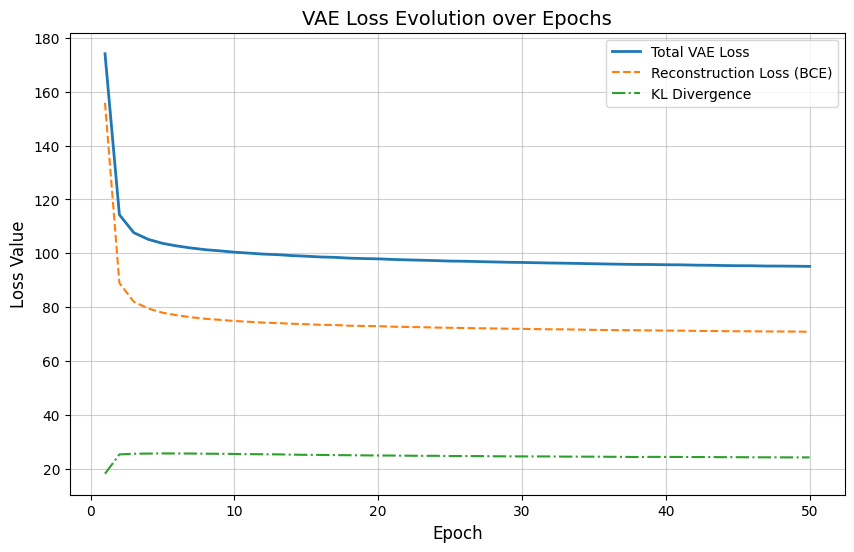

In [54]:
print("\n Training loss (D=128)")
plot_loss_evolution(history_128)

The total VAE loss, reconstruction loss (BCE), and KL divergence show stable and smooth convergence.
The reconstruction loss dominates the total loss, decreasing rapidly during the first few epochs and stabilizing around epoch 10.
The KL divergence increases slightly at the beginning and then plateaus, indicating that the latent space distribution stabilizes.
This pattern suggests that the model efficiently balances reconstruction accuracy and latent regularization.

In [6]:
def load_trained_model(model_class, latent_dims, device, epoch):
    weights_path = f'./vae_snapshots_d{latent_dims}/vae_weights_epoch_{epoch}.pth'
    
    model = model_class(latent_dims=latent_dims).to(device)
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()
    return model

LATENT_DIM = 128
trained_model_128 = load_trained_model(VAE, LATENT_DIM, DEVICE, 50)


 Reconstruction Quality (D=128)


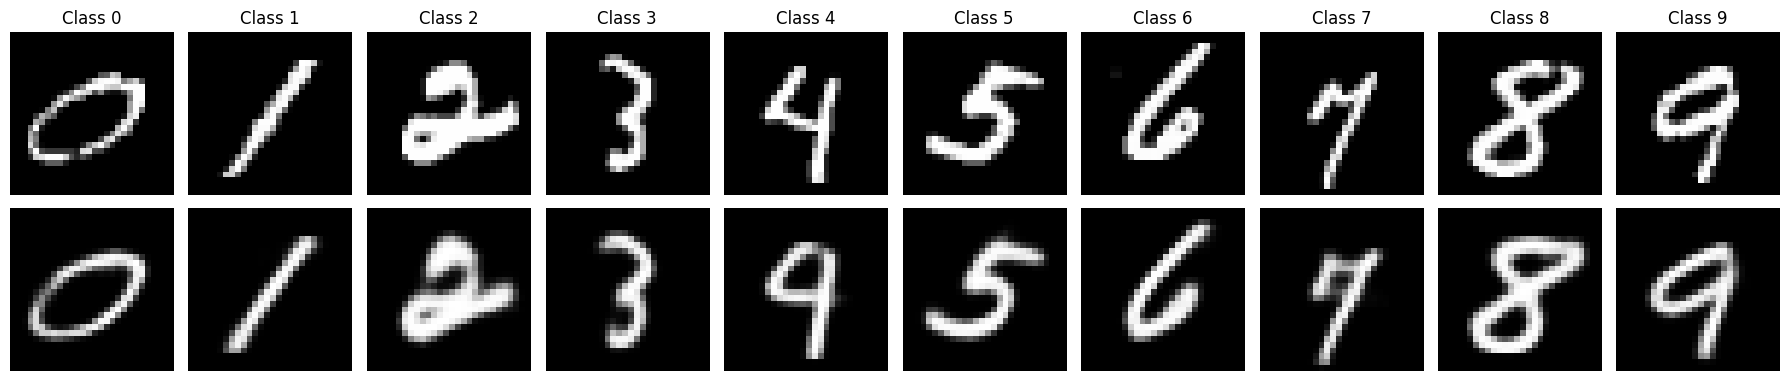


 Latent Space Evolution (D=128)

Generating t-SNE evolution for epochs: [1, 10, 30, 50]...


Processing t-SNE snapshots: 100%|██████████| 4/4 [00:42<00:00, 10.62s/it]


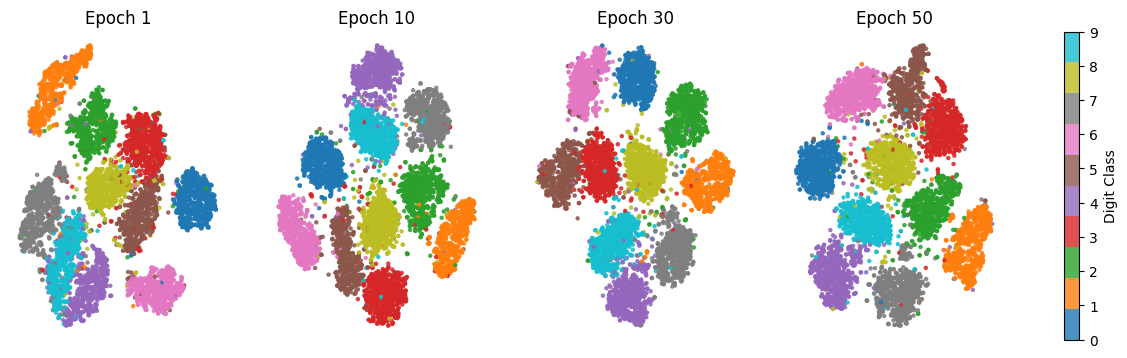


 Generated Samples (D=128)


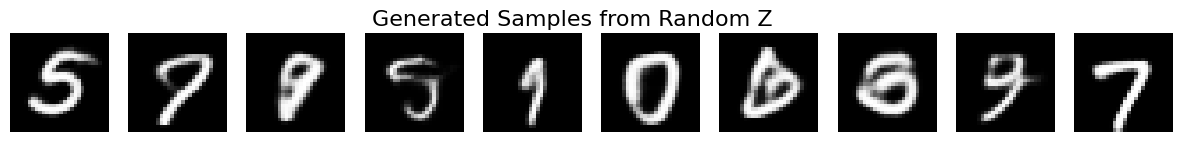


 Latent Space Interpolation (D=128)


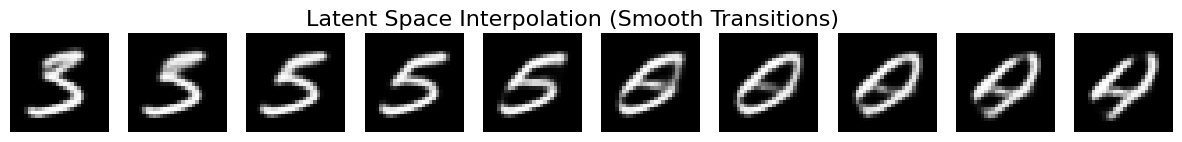

In [9]:

print("\n Reconstruction Quality (D=128)")
visualize_reconstruction(trained_model_128, train_loader, DEVICE)
print("\n Latent Space Evolution (D=128)")
visualize_latent_structure_evolution(VAE, LATENT_DIM, train_loader, DEVICE, [1, 10, 30, 50], weights_dir='./vae_snapshots_d128')
print("\n Generated Samples (D=128)")
generate_samples(trained_model_128, LATENT_DIM, DEVICE)
print("\n Latent Space Interpolation (D=128)")
interpolate_samples(trained_model_128, LATENT_DIM, DEVICE)

### Results for latent dimensions = 128:
* **Reconstruction quality:**    
The reconstruction for each class looks very good. Reconstruction is similar to original images.    

* **Laten Space evolution:**     
The model performed significant improvement over the initial epochs (1-10). While there is little visible improvement after epoch 10, the final t-SNE plot shows that classes are quite well separated and clustered, indicating the model successfully learned feature space.    

* **Generated samples from Random Z vectors:**    
Most images resemble original classes, but for me picture nr 4, 7 and 8 are unclassifable.    

* **Latent Space interpolation:**     
The process shows a smooth and continuous transition from the features of '5' to '4'. However, the generated images at both extremes (the initial '5' and the final '4') do not represent perfect samples of their classes; they appear slightly wobbly.

# VAE training: latent dimensions = 256

In [51]:
LATENT_DIM = 256
EPOCHS = 50
LR = 1e-3

model_256 = VAE(latent_dims=LATENT_DIM)
optimizer_256 = optim.Adam(model_256.parameters(), lr=LR)

print("\n\n--- VAE training latent dimensions = 256 ---")
trained_model_256, history_256 = train_vae(
    model_256, 
    train_loader, 
    optimizer_256, 
    EPOCHS, 
    DEVICE,
    './vae_snapshots_d256'
)



--- VAE training latent dimensions = 256 ---
Starting VAE training for 50 epochs on cuda...


Epoch 1/50: 100%|██████████| 469/469 [00:05<00:00, 88.17it/s]


Epoch 1 done. Loss: 180.7482 (Recon: 161.6879, KL: 19.0603)


Epoch 2/50: 100%|██████████| 469/469 [00:05<00:00, 89.44it/s]


Epoch 2 done. Loss: 119.7262 (Recon: 94.7787, KL: 24.9475)


Epoch 3/50: 100%|██████████| 469/469 [00:05<00:00, 89.83it/s]


Epoch 3 done. Loss: 109.8822 (Recon: 84.8918, KL: 24.9904)


Epoch 4/50: 100%|██████████| 469/469 [00:05<00:00, 90.77it/s]


Epoch 4 done. Loss: 106.5208 (Recon: 81.4671, KL: 25.0537)


Epoch 5/50: 100%|██████████| 469/469 [00:05<00:00, 89.43it/s]


Epoch 5 done. Loss: 104.6969 (Recon: 79.5670, KL: 25.1299)


Epoch 6/50: 100%|██████████| 469/469 [00:05<00:00, 88.98it/s]


Epoch 6 done. Loss: 103.5535 (Recon: 78.4064, KL: 25.1471)


Epoch 7/50: 100%|██████████| 469/469 [00:05<00:00, 88.85it/s]


Epoch 7 done. Loss: 102.6394 (Recon: 77.5661, KL: 25.0733)


Epoch 8/50: 100%|██████████| 469/469 [00:05<00:00, 88.38it/s]


Epoch 8 done. Loss: 102.0179 (Recon: 76.9588, KL: 25.0590)


Epoch 9/50: 100%|██████████| 469/469 [00:05<00:00, 89.14it/s]


Epoch 9 done. Loss: 101.4434 (Recon: 76.3837, KL: 25.0597)


Epoch 10/50: 100%|██████████| 469/469 [00:05<00:00, 89.50it/s]


Epoch 10 done. Loss: 100.9756 (Recon: 75.9547, KL: 25.0209)


Epoch 11/50: 100%|██████████| 469/469 [00:05<00:00, 89.18it/s]


Epoch 11 done. Loss: 100.5705 (Recon: 75.5530, KL: 25.0175)


Epoch 12/50: 100%|██████████| 469/469 [00:05<00:00, 89.96it/s]


Epoch 12 done. Loss: 100.1746 (Recon: 75.2603, KL: 24.9143)


Epoch 13/50: 100%|██████████| 469/469 [00:05<00:00, 84.27it/s]


Epoch 13 done. Loss: 99.8361 (Recon: 74.9251, KL: 24.9110)


Epoch 14/50: 100%|██████████| 469/469 [00:05<00:00, 80.52it/s]


Epoch 14 done. Loss: 99.5717 (Recon: 74.7059, KL: 24.8658)


Epoch 15/50: 100%|██████████| 469/469 [00:05<00:00, 86.88it/s]


Epoch 15 done. Loss: 99.2862 (Recon: 74.4699, KL: 24.8163)


Epoch 16/50: 100%|██████████| 469/469 [00:05<00:00, 91.69it/s]


Epoch 16 done. Loss: 99.0730 (Recon: 74.2775, KL: 24.7956)


Epoch 17/50: 100%|██████████| 469/469 [00:05<00:00, 90.33it/s]


Epoch 17 done. Loss: 98.8798 (Recon: 74.1120, KL: 24.7678)


Epoch 18/50: 100%|██████████| 469/469 [00:05<00:00, 91.35it/s]


Epoch 18 done. Loss: 98.6600 (Recon: 73.9349, KL: 24.7252)


Epoch 19/50: 100%|██████████| 469/469 [00:05<00:00, 90.87it/s]


Epoch 19 done. Loss: 98.4271 (Recon: 73.7262, KL: 24.7008)


Epoch 20/50: 100%|██████████| 469/469 [00:05<00:00, 90.28it/s]


Epoch 20 done. Loss: 98.2976 (Recon: 73.5956, KL: 24.7020)


Epoch 21/50: 100%|██████████| 469/469 [00:05<00:00, 91.16it/s]


Epoch 21 done. Loss: 98.0677 (Recon: 73.4054, KL: 24.6623)


Epoch 22/50: 100%|██████████| 469/469 [00:05<00:00, 90.62it/s]


Epoch 22 done. Loss: 97.9609 (Recon: 73.2975, KL: 24.6634)


Epoch 23/50: 100%|██████████| 469/469 [00:05<00:00, 91.50it/s]


Epoch 23 done. Loss: 97.8259 (Recon: 73.1945, KL: 24.6314)


Epoch 24/50: 100%|██████████| 469/469 [00:05<00:00, 91.21it/s]


Epoch 24 done. Loss: 97.7008 (Recon: 73.0734, KL: 24.6274)


Epoch 25/50: 100%|██████████| 469/469 [00:05<00:00, 91.26it/s]


Epoch 25 done. Loss: 97.5479 (Recon: 72.9717, KL: 24.5761)


Epoch 26/50: 100%|██████████| 469/469 [00:05<00:00, 90.86it/s]


Epoch 26 done. Loss: 97.4009 (Recon: 72.8134, KL: 24.5875)


Epoch 27/50: 100%|██████████| 469/469 [00:05<00:00, 90.90it/s]


Epoch 27 done. Loss: 97.3116 (Recon: 72.7714, KL: 24.5402)


Epoch 28/50: 100%|██████████| 469/469 [00:05<00:00, 87.07it/s]


Epoch 28 done. Loss: 97.1766 (Recon: 72.6607, KL: 24.5159)


Epoch 29/50: 100%|██████████| 469/469 [00:05<00:00, 87.18it/s]


Epoch 29 done. Loss: 97.0246 (Recon: 72.5236, KL: 24.5010)


Epoch 30/50: 100%|██████████| 469/469 [00:05<00:00, 87.47it/s]


Epoch 30 done. Loss: 96.9781 (Recon: 72.4716, KL: 24.5066)


Epoch 31/50: 100%|██████████| 469/469 [00:05<00:00, 91.14it/s]


Epoch 31 done. Loss: 96.8655 (Recon: 72.3791, KL: 24.4864)


Epoch 32/50: 100%|██████████| 469/469 [00:05<00:00, 90.69it/s]


Epoch 32 done. Loss: 96.7648 (Recon: 72.2900, KL: 24.4748)


Epoch 33/50: 100%|██████████| 469/469 [00:05<00:00, 90.31it/s]


Epoch 33 done. Loss: 96.6437 (Recon: 72.2105, KL: 24.4333)


Epoch 34/50: 100%|██████████| 469/469 [00:05<00:00, 92.44it/s]


Epoch 34 done. Loss: 96.5988 (Recon: 72.1659, KL: 24.4329)


Epoch 35/50: 100%|██████████| 469/469 [00:05<00:00, 87.92it/s]


Epoch 35 done. Loss: 96.4973 (Recon: 72.0523, KL: 24.4449)


Epoch 36/50: 100%|██████████| 469/469 [00:05<00:00, 90.44it/s]


Epoch 36 done. Loss: 96.4107 (Recon: 72.0211, KL: 24.3896)


Epoch 37/50: 100%|██████████| 469/469 [00:05<00:00, 91.49it/s]


Epoch 37 done. Loss: 96.3040 (Recon: 71.9234, KL: 24.3805)


Epoch 38/50: 100%|██████████| 469/469 [00:05<00:00, 90.19it/s]


Epoch 38 done. Loss: 96.2447 (Recon: 71.8601, KL: 24.3846)


Epoch 39/50: 100%|██████████| 469/469 [00:05<00:00, 89.38it/s]


Epoch 39 done. Loss: 96.1594 (Recon: 71.7828, KL: 24.3766)


Epoch 40/50: 100%|██████████| 469/469 [00:05<00:00, 88.56it/s]


Epoch 40 done. Loss: 96.1349 (Recon: 71.7696, KL: 24.3654)


Epoch 41/50: 100%|██████████| 469/469 [00:05<00:00, 90.84it/s]


Epoch 41 done. Loss: 96.0497 (Recon: 71.7040, KL: 24.3457)


Epoch 42/50: 100%|██████████| 469/469 [00:05<00:00, 92.04it/s]


Epoch 42 done. Loss: 95.9526 (Recon: 71.6334, KL: 24.3192)


Epoch 43/50: 100%|██████████| 469/469 [00:05<00:00, 92.22it/s]


Epoch 43 done. Loss: 95.8829 (Recon: 71.5644, KL: 24.3185)


Epoch 44/50: 100%|██████████| 469/469 [00:05<00:00, 92.07it/s]


Epoch 44 done. Loss: 95.8278 (Recon: 71.5065, KL: 24.3212)


Epoch 45/50: 100%|██████████| 469/469 [00:05<00:00, 92.56it/s]


Epoch 45 done. Loss: 95.7731 (Recon: 71.4843, KL: 24.2888)


Epoch 46/50: 100%|██████████| 469/469 [00:05<00:00, 91.06it/s]


Epoch 46 done. Loss: 95.7306 (Recon: 71.4514, KL: 24.2792)


Epoch 47/50: 100%|██████████| 469/469 [00:05<00:00, 92.24it/s]


Epoch 47 done. Loss: 95.6588 (Recon: 71.3810, KL: 24.2779)


Epoch 48/50: 100%|██████████| 469/469 [00:05<00:00, 87.46it/s]


Epoch 48 done. Loss: 95.6613 (Recon: 71.3736, KL: 24.2877)


Epoch 49/50: 100%|██████████| 469/469 [00:05<00:00, 88.58it/s]


Epoch 49 done. Loss: 95.5841 (Recon: 71.3441, KL: 24.2400)


Epoch 50/50: 100%|██████████| 469/469 [00:05<00:00, 89.04it/s]

Epoch 50 done. Loss: 95.4757 (Recon: 71.2312, KL: 24.2445)



 Training loss (D=256)


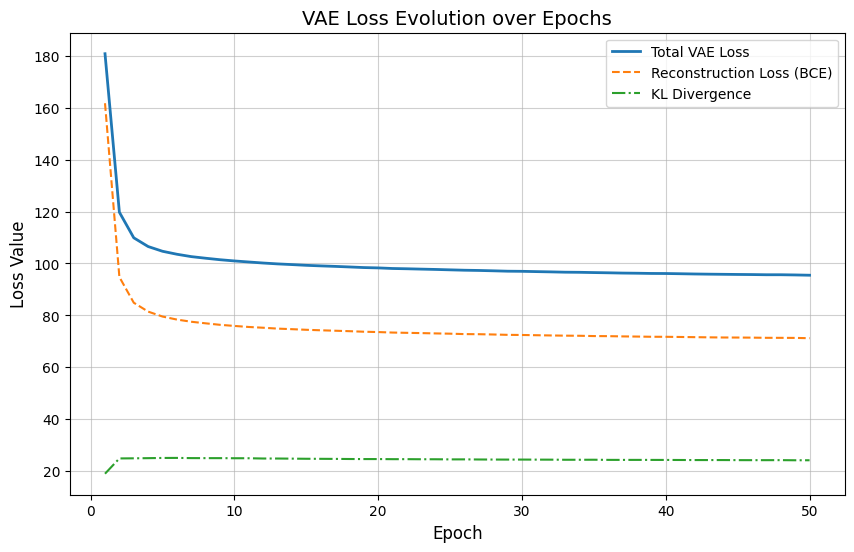

In [55]:
print("\n Training loss (D=256)")
plot_loss_evolution(history_256)

The loss evolution follows a nearly identical pattern to the 128-dimensional case.
The total and reconstruction losses converge to slightly lower values, showing that the larger latent space does not significantly improve learning stability or reconstruction performance.
The KL divergence remains comparable in magnitude, suggesting that the model does not make full use of the increased latent capacity.
This indicates that a larger latent space might be partially redundant for MNIST-scale data, offering no substantial training advantage.

In [10]:
LATENT_DIM = 256
trained_model_256 = load_trained_model(VAE, LATENT_DIM, DEVICE, 50)


 Reconstruction Quality (D=256)


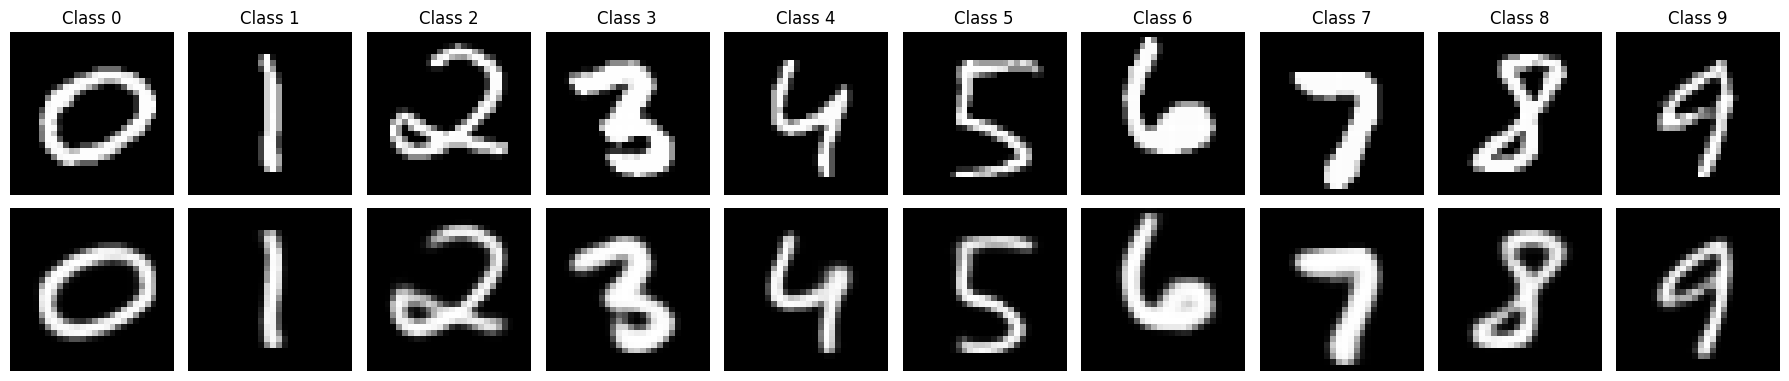


 Latent Space Evolution (D=256)

Generating t-SNE evolution for epochs: [1, 10, 30, 50]...


Processing t-SNE snapshots: 100%|██████████| 4/4 [00:43<00:00, 10.99s/it]


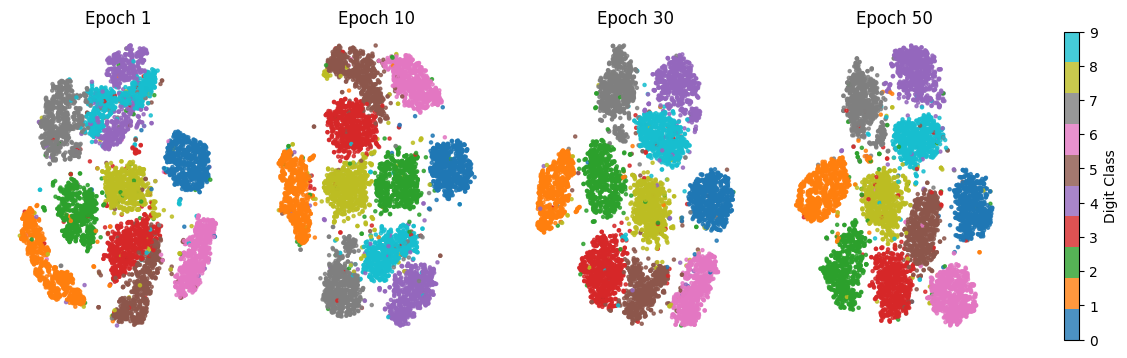


 Generated Samples (D=256)


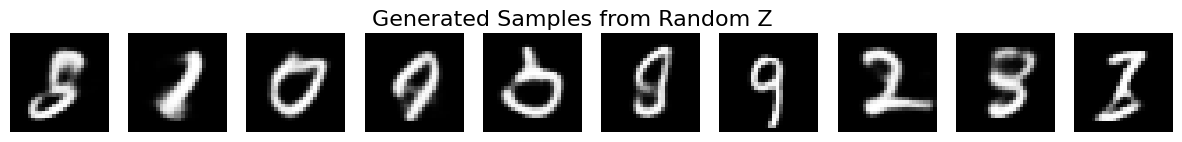


 Latent Space Interpolation (D=256)


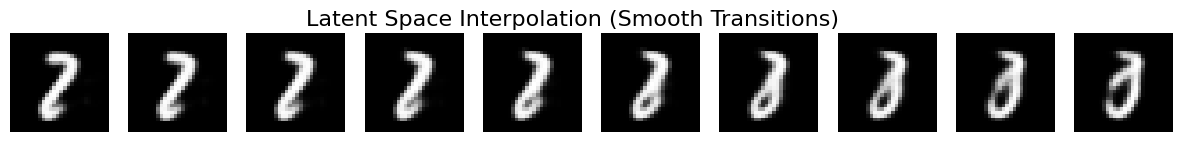

In [11]:
print("\n Reconstruction Quality (D=256)")
visualize_reconstruction(trained_model_256, train_loader, DEVICE)
print("\n Latent Space Evolution (D=256)")
visualize_latent_structure_evolution(VAE, LATENT_DIM, train_loader, DEVICE, [1, 10, 30, 50], weights_dir='./vae_snapshots_d256')
print("\n Generated Samples (D=256)")
generate_samples(trained_model_256, LATENT_DIM, DEVICE)
print("\n Latent Space Interpolation (D=256)")
interpolate_samples(trained_model_256, LATENT_DIM, DEVICE)

### Results for latent dimensions = 256:
* **Reconstruction quality:**    
The reconstruction for each class looks very good. Reconstruction is similar to original images.    

* **Laten Space evolution:**     
Again, the model performed significant improvement over the initial epochs (1-10). We can especially see the improvement on classes 9 and 4, which were overlapping. After epoch 10 there is only a little visible improvement. 

* **Generated samples from Random Z vectors:**    
Most images doesn't actually resemble any specific digit. They seem to be a mixture of different digits.  

* **Latent Space interpolation:**     
The process shows continuous transition from the features of '2' to '8'. However, the generated images at both extremes, especially the initial 8 digit, do not represent perfect and clear samples of their classes.

## Comaprison of latent dimensionality (128 vs 256):
* **Loss curves**:     
Both models show similar convergence trends — fast initial improvement followed by gradual stabilization.
The lack of significant difference between the 128 and 256 latent dimensions implies that increasing latent dimensionality beyond a certain point does not necessarily enhance model performance, especially for relatively simple datasets like MNIST.
* **Reconstruction quality**:     
Both models achieve very good reconstruction quality — the decoded images are visually close to the originals.
* **Latent Space evolution**:     
In both cases, the latent space becomes more organized over the first 10 epochs, after which improvements slow down.    
* **Generation from Random Z Vectors**:     
The model with 128 dimensions produces more coherent and recognizable digits, while the 256-dimensional model often generates ambiguous or mixed shapes that do not resemble any specific class.
This suggests that a larger latent space becomes too sparse. Random points may fall into regions that the decoder has not effectively learned, resulting in unrealistic samples.
* **Latent Space Interpolation**:     
In both models, interpolation between two latent points demonstrates a smooth transition of features, showing that the VAE successfully learned a continuous representation of the data features.
However, the 256-dimensional model’s interpolations tend to produce less clean digits, indicating that the manifold (low-dimensional, continuous surface embedded within a high-dimensional space where the essential structure of the data lives) is less well-structured and the decoder generalizes worse between known regions.